In [42]:
import cv2
import torch
from torch import optim
from torch.autograd.functional import jacobian
from PIL import Image
import OpenEXR, Imath
import numpy as np
from matplotlib import pyplot as plt
import time
import skfmm
from scipy.optimize import minimize, Bounds

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
def exr_to_np(path):
    y_resolution = 540
    x_resolution = 810
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    
    rgb_exr = OpenEXR.InputFile(path)
    rgb_dw = rgb_exr.header()['dataWindow']
    rgb_size = (rgb_dw.max.x - rgb_dw.min.x + 1, rgb_dw.max.y - rgb_dw.min.y + 1)
    r_str = rgb_exr.channel('R', pt)
    g_str = rgb_exr.channel('G', pt)
    b_str = rgb_exr.channel('B', pt)
    rgb_img = np.zeros((y_resolution, x_resolution, 3))
    r_ch = Image.frombytes("F", rgb_size, r_str)
    g_ch = Image.frombytes("F", rgb_size, g_str)
    b_ch = Image.frombytes("F", rgb_size, b_str)
    rgb_img[: ,:, 2] = np.array(r_ch.getdata()).reshape(y_resolution, x_resolution)
    rgb_img[: ,:, 1] = np.array(g_ch.getdata()).reshape(y_resolution, x_resolution)
    rgb_img[: ,:, 0] = np.array(b_ch.getdata()).reshape(y_resolution, x_resolution)
    min_val = rgb_img.min()
    max_val = rgb_img.max() 
    rgb_img = ((rgb_img - min_val)/(max_val - min_val) * 255.0).astype(np.uint8)
    return rgb_img

In [4]:
def depth_exr_to_np(path):
    y_resolution = 540
    x_resolution = 810
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    
    depth_exr = OpenEXR.InputFile(path)
    depth_dw = depth_exr.header()['dataWindow']
    depth_size = (depth_dw.max.x - depth_dw.min.x + 1, depth_dw.max.y - depth_dw.min.y + 1)
    depth_str = depth_exr.channel('R', pt)
    depth = Image.frombytes("F", depth_size, depth_str)
    depth_img = np.array(depth.getdata()).reshape(y_resolution, x_resolution)
    depth_img = depth_img * 1000.0
    return depth_img

In [5]:
def threshold(img, v_min, v_max):
    '''
    threshold an img using v_min and v_max; img.shape[2] = v_min.shape[0] = v_max.shape[0]
    '''
    H, W, C = img.shape
    mask =  np.ones((H, W))
    for i in range(C):
        mask_i_1 = img[:, :, i] > v_min[i]
        mask_i_2 = img[:, :, i] < v_max[i]
        mask_i = np.logical_and(mask_i_1, mask_i_2)
        mask = np.logical_and(mask, mask_i)
    return mask

In [147]:
def sign_nozero(p):
    '''
    Similar to np.sign but output is 1 if value is zero
    '''
    p = p.astype(float)
    s = np.sign(p)
    s[s == 0] = 1
    return s

In [176]:
class indi_pt_tracker:
    def __init__(self, H, W, l, debug=False):
        self.H = H
        self.W = W
        self.l = l
        self.lam = 10.
        self.debug = debug
        
    def set_obs(self, mask, rgb_np=None, depth_np=None):
#         plt.imshow(mask)
#         plt.show()
        mask = (~mask).astype(np.uint8)
        phi = np.where(mask, 0, -1) + 0.5
        dist = skfmm.distance(phi, dx = 1)
#         plt.imshow(dist)
#         plt.show()
        dist = dist - dist.min() # - 1
        sobelx = cv2.Sobel(dist,cv2.CV_64F,1,0,ksize=-1)/30.56
        sobely = cv2.Sobel(dist,cv2.CV_64F,0,1,ksize=-1)/30.56
#         plt.imshow(sobelx)
#         plt.show()
        
        self.mask = mask
        self.dist = dist
        self.dist_x = sobelx
        self.dist_y = sobely
                
        self.rgb_np = rgb_np
        self.depth_np = depth_np
    
    def p2ang(self, p):
        '''
        Input: p: numpy array (Np, 2)
        Output: ang: numpy array (Ne)
        '''
        p = p.astype(float)
        dx = p[:-1, 1] - p[1:, 1]
        dy = p[:-1, 0] - p[1:, 0]
        ang_0_pi = np.arccos(dx/(np.square(dx)+np.square(dy)))
        dy[ang_0_pi==0] += 0.01 # singular value for ang_0_pi = 0 or anf_0_pi = pi
        ang = np.sign(dy)*ang_0_pi
        return ang
    
    def hard_constrain(self, p):
        '''
        p: numpy array (Np,2)
        '''
        p = np.maximum(p, np.zeros_like(p))
        p[:,0] = np.minimum(p[:,0], np.ones(p[:,0].shape, dtype=int)*(self.H-1))
        p[:,1] = np.minimum(p[:,1], np.ones(p[:,1].shape, dtype=int)*(self.W-1))
        return p
    
    def set_init(self, p):
        '''
        p: numpy array (Np,2)
        '''
        self.p = p
        self.ang = self.p2ang(self.p)
        lb = np.zeros(p.shape[0]*2)
        ub = np.ones(p.shape[0]*2)
        ub[0::2] = self.H-1
        ub[1::2] = self.W-1
        self.bound = Bounds(lb, ub)
#         for i in range(p.shape[0]//2):
#             self.bound.append((0,self.H-1))
#             self.bound.append((0,self.W-1))
    
    def obj_fn(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        loss = 0
        p = p.reshape(-1,2).astype(int)
        if self.debug:
            print('In obj fn')
            print(p)
        p = self.hard_constrain(p)
        loss += np.sum(np.square(self.dist[p[:,0], p[:,1]]))
#         d_ang = self.p2ang(p.reshape(-1,2)) - self.ang
#         loss += np.sum(self.lam*np.square(d_ang))
        return loss
    
    def jac_fn(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        p = p.reshape(-1,2).astype(int)
        p = self.hard_constrain(p)
        # Jacobian for distance residuals
        J_D = np.zeros(p.shape)
        J_D[:, 1] = self.dist_x[p[:, 0], p[:, 1]]
        J_D[:, 0] = self.dist_y[p[:, 0], p[:, 1]]
        J_D = self.dist[p[:, 0], p[:, 1]][:, None]*J_D
        
        # Jacobian for the angle change
#         J_ang = np.zeros(p.shape)
#         dx = p[:-1, 1] - p[1:, 1]
#         dy = p[:-1, 0] - p[1:, 0]
#         l = np.square(dx)+np.square(dy)
#         d_ang = self.p2ang(p) - self.ang
#         J_ang[1:, 0] = -2*self.lam*d_ang*dx/l
#         J_ang[1:, 1] = 2*self.lam*d_ang*dy/l
#         J_ang[:-1,0] = 2*self.lam*d_ang*dx/l
#         J_ang[:-1,1] = -2*self.lam*d_ang*dy/l
        
        if self.debug:
            print('In jac fn')
            print(J_D)
            print(l)
#         return ((J_D+J_ang).reshape(-1))
        return J_D.reshape(-1)
    
    def fixed_len(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        p = p.reshape(-1,2)
        return np.sum(np.abs(np.linalg.norm(p[1:] - p[:-1], axis=1) - self.l))
    
    def fixed_len_i(self, p, i):
        p = p.reshape(-1,2)
        return np.linalg.norm(p[i]-p[i+1])-self.l
        
    def fixed_len_lb(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        ratio = 0.95
        p = p.reshape(-1,2)
        return np.sum(np.linalg.norm(p[1:] - p[:-1], axis=1) - ratio*self.l)
    
    def fixed_len_ub(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        ratio = 1.05
        p = p.reshape(-1,2)
        return np.sum(ratio*self.l - np.linalg.norm(p[1:] - p[:-1], axis=1))
    
    def fixed_len_jac(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        p = p.reshape(-1,2)
        dp = p[1:] - p[:-1]
        dp_norm = np.linalg.norm(dp, axis=1)
        print(dp)
        print(dp_norm)
        
        J = np.zeros_like(p)
        J[:-1, 0] += np.sign(dp_norm-self.l)*(p[:-1,0]-p[1:,0])/dp_norm
        J[:-1, 1] += np.sign(dp_norm-self.l)*(p[:-1,1]-p[1:,1])/dp_norm
        J[1:, 0] += np.sign(dp_norm-self.l)*(p[1:,0]-p[:-1,0])/dp_norm
        J[1:, 1] += np.sign(dp_norm-self.l)*(p[1:,1]-p[:-1,1])/dp_norm
        if (J==0).all():
            J[:,:] = 1e-6
        if self.debug:
            print('In constrain jac')
            print(J)
#         J = np.sign(dp_norm-self.l)[:, None] * J
        return J.reshape(-1)

    def fixed_len_i_jac(self, p, i):
        p = p.reshape(-1,2)
        J = np.zeros_like(p)
        norm = np.linalg.norm(p[i]-p[i+1])
        J[i, 0] = (p[i, 0]-p[i+1, 0])/norm
        J[i, 1] = (p[i, 1]-p[i+1, 1])/norm
        J[i+1, 0] = (p[i+1, 0]-p[i, 0])/norm
        J[i+1, 1] = (p[i+1, 1]-p[i, 1])/norm
        return J.reshape(-1)

    def fixed_len_lb_jac(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        ratio = 0.99
        p = p.reshape(-1,2)
        dp = p[1:] - p[:-1]
        dp_norm = np.linalg.norm(dp, axis=1)
        print(dp)
        print(dp_norm)
        
        J = np.zeros_like(p)
        J[:-1, 0] += (p[:-1,0]-p[1:,0])/dp_norm
        J[:-1, 1] += (p[:-1,1]-p[1:,1])/dp_norm
        J[1:, 0] += (p[1:,0]-p[:-1,0])/dp_norm
        J[1:, 1] += (p[1:,1]-p[:-1,1])/dp_norm
        if self.debug:
            print('In constrain jac')
            print(J)
#         J = np.sign(dp_norm-self.l)[:, None] * J
        return J.reshape(-1)

    def fixed_len_ub_jac(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        ratio = 1.01
        p = p.reshape(-1,2)
        dp = p[1:] - p[:-1]
        dp_norm = np.linalg.norm(dp, axis=1)
        print(dp)
        print(dp_norm)
        
        J = np.zeros_like(p)
        J[:-1, 0] += -(p[:-1,0]-p[1:,0])/dp_norm
        J[:-1, 1] += -(p[:-1,1]-p[1:,1])/dp_norm
        J[1:, 0] += -(p[1:,0]-p[:-1,0])/dp_norm
        J[1:, 1] += -(p[1:,1]-p[:-1,1])/dp_norm
        if self.debug:
            print('In constrain jac')
            print(J)
#         J = np.sign(dp_norm-self.l)[:, None] * J
        return J.reshape(-1)
    
    def step(self):
        p = self.p.copy().reshape(-1)
        cons = []
        fixed_len = {
            'type': 'eq',
            'fun': self.fixed_len,
            'jac': self.fixed_len_jac
        }
        fixed_len_lb = {
            'type': 'ineq',
            'fun': self.fixed_len_lb,
            'jac': self.fixed_len_lb_jac
        }
        fixed_len_ub = {
            'type': 'ineq',
            'fun': self.fixed_len_ub,
            'jac': self.fixed_len_ub_jac
        }
        opt = {
            'maxiter': 5000
        }
#         cons.append(fixed_len_lb)
#         cons.append(fixed_len_ub)
        for i in range(p.shape[0]//2-1):
            fixed_len_i = {
                'type': 'eq',
                'fun': self.fixed_len_i,
                'jac': self.fixed_len_i_jac,
                'args': [i]
            }
            cons.append(fixed_len_i)
        res = minimize(self.obj_fn, p, jac=self.jac_fn, constraints=cons, method='SLSQP', options=opt)
        print(res)
        self.p = res.x.reshape(-1, 2)
        self.ang = self.p2ang(self.p)
        
    def vis(self, save_dir=None, idx=0):
        if self.rgb_np is not None:
            vis_img = self.rgb_np.copy()
        else:
            vis_img = np.zeros((self.H, self.W))

        radius = 5
        color = (255, 0, 0)
        thickness = 3

        for i in range(self.p.shape[0]):
            vis_img = cv2.circle(vis_img, (int(self.p[i][1]), int(self.p[i][0])), radius, color, thickness)
        plt.imshow(vis_img)
        if save_dir is not None:
            import pathlib
            pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)
            plt.savefig(save_dir+"frame_"+'{0:03d}'.format(idx)+".png", dpi=300)
        plt.show()

In obj fn
[[180 180]
 [180 200]
 [180 220]
 [180 240]
 [180 260]
 [180 280]
 [180 300]
 [180 320]
 [180 340]
 [180 360]
 [180 380]]
In jac fn
[[-2.22920087e+01 -2.22920087e+01]
 [-2.29435191e+01 -3.50149909e-01]
 [-2.30366492e+01  2.26090234e-12]
 [-2.30366492e+01 -2.22765378e-12]
 [-2.30366492e+01 -3.32485639e-14]
 [-2.30366492e+01  2.26090234e-12]
 [-2.30366492e+01 -2.22765378e-12]
 [-2.30366492e+01 -3.32485639e-14]
 [-2.30366492e+01  2.26090234e-12]
 [-2.30366492e+01 -2.22765378e-12]
 [-2.30366492e+01  2.54735151e-12]]
20
In obj fn
[[202 182]
 [202 202]
 [203 222]
 [203 242]
 [203 262]
 [203 282]
 [203 302]
 [203 322]
 [203 342]
 [203 362]
 [203 382]]
In jac fn
[[  0.         -20.93039979]
 [  0.          -0.07323943]
 [  1.04712042   0.        ]
 [  1.04712042   0.        ]
 [  1.04712042   0.        ]
 [  1.04712042   0.        ]
 [  1.04712042   0.        ]
 [  1.04712042   0.        ]
 [  1.04712042   0.        ]
 [  1.04712042   0.        ]
 [  1.04712042   0.        ]]
20
In o

In jac fn
[[-0.29128956 -1.76922886]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          2.01460877]]
20
In obj fn
[[ 56160 -13580]
 [ -3736  -9198]
 [-12035  -9404]
 [-44628  -8835]
 [-29747  -8317]
 [ 49245 -11193]
 [ 34612 -11066]
 [ -3122 -11058]
 [ -8163 -11045]
 [ 11157 -11029]
 [-47715 -11576]]
In obj fn
[[ 5797 -1178]
 [ -190  -721]
 [-1021  -724]
 [-4280  -649]
 [-2792  -579]
 [ 5107  -849]
 [ 3643  -818]
 [ -129  -799]
 [ -633  -780]
 [ 1298  -760]
 [-4589  -797]]
In obj fn
[[ 761   62]
 [ 163  125]
 [  80  143]
 [-245  169]
 [ -97  194]
 [ 693  185]
 [ 547  206]
 [ 169  226]
 [ 119  245]
 [ 312  265]
 [-276  280]]
In obj fn
[[257 186]
 [199 210]
 [190 230]
 [157 250]
 [172 271]
 [251 288]
 [237 308]
 [199 328]
 [194 348]
 [213 368]
 [154 388]]
In obj fn
[[207 198]
 [202 21

In obj fn
[[206 199]
 [203 219]
 [202 239]
 [202 259]
 [200 279]
 [200 299]
 [203 319]
 [202 339]
 [201 359]
 [204 379]
 [197 399]]
In obj fn
[[202 200]
 [203 220]
 [202 239]
 [202 259]
 [202 279]
 [202 299]
 [203 319]
 [202 339]
 [202 359]
 [203 379]
 [202 399]]
In obj fn
[[201 200]
 [202 220]
 [202 240]
 [202 260]
 [202 279]
 [202 299]
 [202 319]
 [202 339]
 [202 359]
 [202 379]
 [202 399]]
In obj fn
[[201 200]
 [202 220]
 [202 240]
 [202 260]
 [202 279]
 [202 299]
 [202 319]
 [202 339]
 [202 359]
 [202 379]
 [202 399]]
In obj fn
[[201 200]
 [202 220]
 [202 240]
 [202 260]
 [202 279]
 [202 299]
 [202 319]
 [202 339]
 [202 359]
 [202 379]
 [202 399]]
In obj fn
[[201 200]
 [202 220]
 [202 240]
 [202 260]
 [202 279]
 [202 299]
 [202 319]
 [202 339]
 [202 359]
 [202 379]
 [202 399]]
In obj fn
[[201 200]
 [202 220]
 [202 240]
 [202 260]
 [202 279]
 [202 299]
 [202 319]
 [202 339]
 [202 359]
 [202 379]
 [202 399]]
In obj fn
[[201 200]
 [202 220]
 [202 240]
 [202 260]
 [202 279]
 [202 299]


In obj fn
[[201 200]
 [202 219]
 [202 239]
 [202 259]
 [202 279]
 [202 299]
 [202 319]
 [202 339]
 [202 359]
 [202 379]
 [202 399]]
In jac fn
[[-0.29128956 -1.76922886]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          2.01460877]]
20
In obj fn
[[ 537428 -335687]
 [ 178716 -314764]
 [ 128614 -316184]
 [ 139705 -316381]
 [  89419 -317971]
 [   5404 -315213]
 [ 187628 -316732]
 [   4649 -316699]
 [-217811 -317429]
 [ 251890 -318737]
 [-420399 -335894]]
In obj fn
[[ 53924 -33388]
 [ 18054 -31278]
 [ 13043 -31402]
 [ 14153 -31404]
 [  9123 -31545]
 [   722 -31251]
 [ 18945 -31385]
 [   647 -31364]
 [-21598 -31418]
 [ 25371 -31531]
 [-41857 -33229]]
In obj fn
[[ 5574 -3158]
 [ 1988 -2929]
 [ 1486 -2924]
 [ 1597 -2906]
 [ 1094 -2902]
 [  254 -2855]
 [ 2077 -2850]
 [  247 -2830]
 [-1977 -

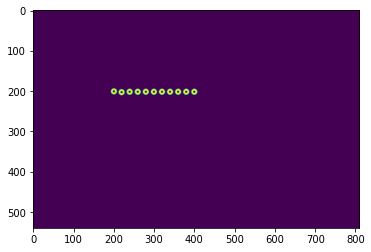

In [177]:
# sanity check for LSLQP
H = 540
W = 810
l = 20
simple_tracker = indi_pt_tracker(H, W, l, debug=True)
q = np.zeros((11,2))
q[:, 0] = 180
q[:, 1] = np.arange(180, 381, 20)
simple_tracker.set_init(q)
mask = np.zeros((H, W), dtype=bool)
mask[200:205, 200:400] = True
simple_tracker.set_obs(mask)
simple_tracker.step()
simple_tracker.vis()

     fun: 19.01039598651986
     jac: array([-5.05014025e-01, -2.31999995e-02, -5.23560209e-01,  0.00000000e+00,
       -5.23560209e-01,  0.00000000e+00,  5.23560209e-01,  0.00000000e+00,
        5.23560209e-01,  9.59093189e-16, -5.25764738e-01, -4.28740921e-03,
       -7.35444645e-01,  6.00885149e-02,  1.04711889e+00,  1.41353995e-05,
       -5.23560209e-01,  6.97522319e-16, -5.23560209e-01,  0.00000000e+00,
       -5.23560209e-01,  0.00000000e+00,  5.23560209e-01,  0.00000000e+00,
        5.23560209e-01,  0.00000000e+00,  5.23560209e-01,  0.00000000e+00,
        5.23560209e-01,  0.00000000e+00,  5.23560209e-01,  0.00000000e+00,
       -5.23560209e-01,  0.00000000e+00, -5.23560209e-01,  0.00000000e+00,
       -5.23560209e-01,  2.74940047e-14])
 message: 'Optimization terminated successfully'
    nfev: 7376
     nit: 1024
    njev: 1024
  status: 0
 success: True
       x: array([275.85111912,  40.50131507, 275.69203839,  60.50068243,
       275.55851311,  80.50023666, 276.18952436, 10

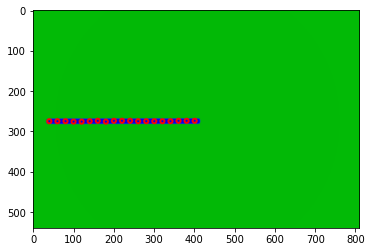

     fun: 44.126392134027384
     jac: array([ 3.12261964e+00, -6.93563170e-02,  3.14136126e+00,  0.00000000e+00,
        3.14136126e+00,  0.00000000e+00,  5.23560209e-01,  0.00000000e+00,
        5.23560209e-01, -1.74380580e-16,  5.12772501e-01, -7.01327128e-03,
        3.14648005e-02,  6.47459522e-02,  7.14320017e-18,  1.73127489e-16,
        5.23560209e-01,  2.20882068e-15,  5.23560209e-01,  0.00000000e+00,
        5.23560209e-01,  0.00000000e+00, -2.09424084e+00,  0.00000000e+00,
       -5.23560209e-01,  0.00000000e+00, -5.23560209e-01,  0.00000000e+00,
       -5.23560209e-01,  0.00000000e+00, -5.23560209e-01,  0.00000000e+00,
       -5.23560209e-01,  0.00000000e+00, -5.23560209e-01,  0.00000000e+00,
       -5.23560209e-01, -4.79546594e-15])
 message: 'Optimization terminated successfully'
    nfev: 8601
     nit: 1205
    njev: 1203
  status: 0
 success: True
       x: array([278.49515078,  40.10489847, 278.62305978,  60.10448946,
       278.58907386,  80.10446058, 276.23114938,  

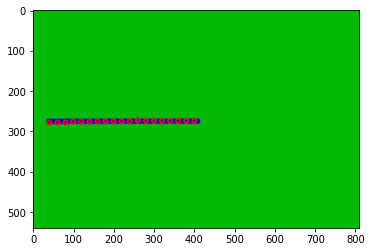

     fun: 93.72116363394778
     jac: array([-7.32984293e+00,  1.82354637e-09, -2.09256696e-14,  0.00000000e+00,
       -2.09256696e-14,  0.00000000e+00, -1.03934781e+00,  7.14106217e-03,
        0.00000000e+00,  0.00000000e+00, -1.04712042e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.06240911e-04,  3.19892840e-04,  2.09256696e-14,  0.00000000e+00,
       -1.04712042e+00,  0.00000000e+00, -1.86005952e-14,  0.00000000e+00,
       -2.09424084e+00,  0.00000000e+00, -1.04712042e+00,  0.00000000e+00,
       -3.14136126e+00,  0.00000000e+00, -3.14136126e+00,  0.00000000e+00,
       -2.29912243e+00,  9.03205487e-01, -2.09424076e+00,  2.73185546e-07,
       -3.14136126e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 8970
     nit: 1100
    njev: 1099
  status: 0
 success: True
       x: array([268.56860371,  44.62588961, 275.67571094,  63.32051529,
       275.76393253,  83.32032059, 274.55198656, 10

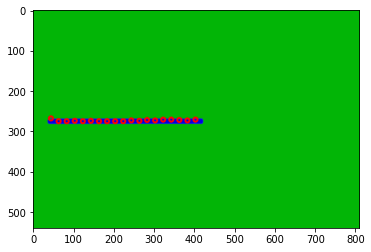

     fun: 135.68791711764288
     jac: array([-1.04712042e+00, -7.26585749e-16, -4.65014879e-15,  1.04349571e-25,
       -1.04712042e+00, -1.65661551e-15,  2.21748387e-27, -8.13889686e-27,
       -2.09424084e+00,  0.00000000e+00, -2.09424084e+00,  0.00000000e+00,
       -1.04712042e+00,  0.00000000e+00, -2.09424084e+00,  4.89718795e-14,
       -1.04712042e+00,  0.00000000e+00, -3.14136126e+00,  0.00000000e+00,
       -2.09424084e+00,  0.00000000e+00, -3.14136126e+00,  0.00000000e+00,
       -4.18848168e+00,  0.00000000e+00, -2.29912243e+00,  9.03205487e-01,
       -3.14136126e+00,  0.00000000e+00, -3.14136126e+00,  0.00000000e+00,
       -5.23560209e+00,  0.00000000e+00, -4.18848168e+00,  0.00000000e+00,
       -3.57663929e+00,  1.51611179e+00])
 message: 'Optimization terminated successfully'
    nfev: 2905
     nit: 532
    njev: 532
  status: 0
 success: True
       x: array([274.49044746,  66.55821692, 275.26525638,  86.54320306,
       274.07552506, 106.50778507, 275.94540551, 126

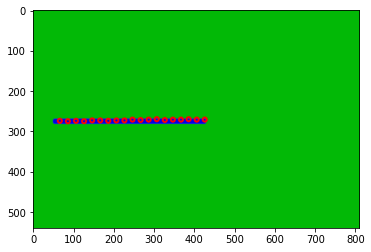

     fun: 8.262091827860017
     jac: array([-8.83528271e-15, -5.39502386e-29, -1.02303273e-14,  0.00000000e+00,
       -1.02303273e-14,  5.11107524e-30,  1.04712042e+00, -4.06888019e-15,
        1.04712042e+00,  0.00000000e+00,  1.04712042e+00,  0.00000000e+00,
        1.04712042e+00,  1.13347377e-15, -1.94258666e-13,  6.75213488e-13,
       -7.90525295e-15,  0.00000000e+00,  1.02303273e-14,  0.00000000e+00,
        1.02303273e-14,  0.00000000e+00,  1.02303273e-14,  0.00000000e+00,
        1.02303273e-14,  0.00000000e+00, -1.19589829e-03,  1.32859522e-05,
        1.04712034e+00, -7.73351293e-08,  0.00000000e+00,  5.67897249e-29,
        1.77324186e+00,  6.34240989e-01,  7.90525295e-15,  0.00000000e+00,
        1.39079285e-01,  1.58157378e-01])
 message: 'Optimization terminated successfully'
    nfev: 9823
     nit: 1269
    njev: 1269
  status: 0
 success: True
       x: array([275.57129492,  70.92394724, 275.42985589,  90.92344709,
       275.17633739, 110.92184026, 276.24700593, 13

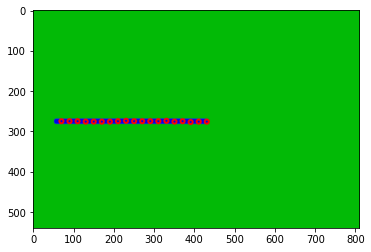

     fun: 1.0053498512238432
     jac: array([-2.88309197e-14, -2.86831323e-21, -9.30029759e-15,  0.00000000e+00,
       -9.30029759e-15,  4.64643203e-30,  2.31289061e-29, -4.29536828e-29,
       -1.04712042e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.11107524e-29, -3.41981990e-10, -1.62908472e-09,
       -1.88645141e-27,  7.52412227e-27,  9.30029759e-15,  0.00000000e+00,
        9.30029759e-15,  0.00000000e+00,  1.48738642e-14,  6.35622975e-18,
        1.42923107e-04, -1.27295254e-04,  0.00000000e+00,  1.54881068e-29,
        1.40941772e-28,  6.68569943e-29,  7.68412236e-04, -1.30992661e-03,
       -9.30029759e-15,  0.00000000e+00,  6.97522319e-15,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 7014
     nit: 1013
    njev: 1013
  status: 0
 success: True
       x: array([275.54975445,  70.94803716, 275.420008  ,  90.94761631,
       275.15492999, 110.94585957, 275.16819079, 1

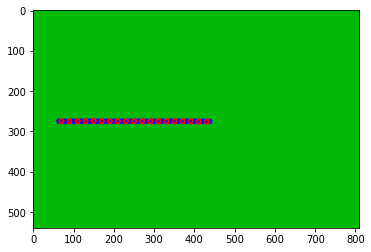

     fun: 0.05553812642179908
     jac: array([-1.97213137e-02, -9.11018630e-02, -1.02303273e-14,  0.00000000e+00,
       -1.02303273e-14,  3.40738349e-30, -3.71714563e-29, -4.36764611e-29,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -3.40738349e-30,  3.66293725e-29,
       -7.68412236e-04,  1.30992661e-03, -1.52815987e-28,  7.06773939e-29,
       -7.68412236e-04,  1.30992661e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.11034111e-20,  7.22351812e-20,
       -5.99178167e-09, -2.22209850e-10, -1.02303273e-14,  0.00000000e+00,
       -1.02303273e-14,  0.00000000e+00,  7.90525295e-15,  0.00000000e+00,
        7.90525295e-15,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 11477
     nit: 1305
    njev: 1305
  status: 0
 success: True
       x: array([276.        ,  70.99984063, 275.71105433,  90.99775332,
       275.29979989, 110.99352465, 275.24461034,

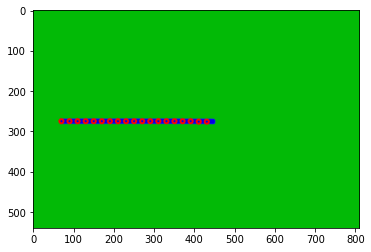

     fun: 21.34953469203186
     jac: array([ 4.97756398e-01, -8.16886997e-01,  5.58017855e-15,  0.00000000e+00,
        1.04643807e+00,  6.12410347e-03,  2.09424084e+00,  0.00000000e+00,
       -1.04712042e+00,  0.00000000e+00, -1.04712042e+00,  0.00000000e+00,
       -2.09424084e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.09424084e+00,  0.00000000e+00,
        1.04712042e+00,  0.00000000e+00,  0.00000000e+00,  4.25922936e-29,
        2.08005546e+00,  5.44597776e-02,  5.58017855e-15,  0.00000000e+00,
        5.58017855e-15,  0.00000000e+00,  5.58017855e-15,  0.00000000e+00,
        5.58017855e-15,  0.00000000e+00, -7.90525295e-15,  0.00000000e+00,
       -7.90525295e-15,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 3482
     nit: 593
    njev: 593
  status: 0
 success: True
       x: array([276.74017412,  76.86566872, 276.49690037,  96.86418913,
       277.15628073, 116.85331669, 277.8687788 , 136.

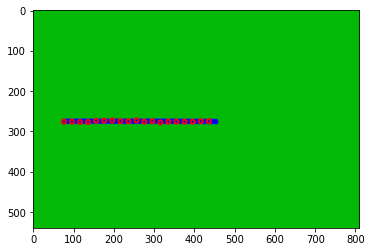

     fun: 0.44872905337106755
     jac: array([-3.19370362e-02, -1.47034536e-01,  7.05524006e-02, -1.17493349e-17,
        7.19219900e-02,  7.99024572e-04,  5.63968077e-16,  0.00000000e+00,
        5.63968077e-16,  0.00000000e+00,  5.63968077e-16,  0.00000000e+00,
        5.63968077e-16,  0.00000000e+00,  5.63968077e-16,  0.00000000e+00,
        5.63968077e-16,  0.00000000e+00,  5.63968077e-16,  0.00000000e+00,
        1.19059927e-15,  2.89816929e-16,  7.05524006e-02,  2.58485369e-16,
       -7.05524006e-02,  0.00000000e+00,  7.05524006e-02,  0.00000000e+00,
       -7.05524006e-02,  0.00000000e+00, -7.05524006e-02,  0.00000000e+00,
        7.05524006e-02,  0.00000000e+00, -7.05524006e-02,  0.00000000e+00,
       -7.05524006e-02,  0.00000000e+00])
 message: 'Positive directional derivative for linesearch'
    nfev: 1890
     nit: 317
    njev: 313
  status: 8
 success: False
       x: array([275.17353574,  84.0000052 , 276.01413937,  97.71408361,
       276.2534901 , 117.43445429, 275.2

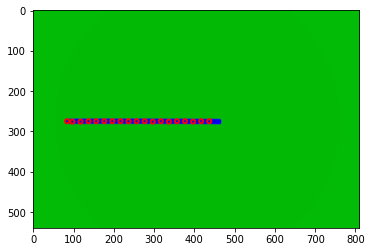

     fun: 4.667359974631357
     jac: array([-7.79841388e-01, -7.79771862e-01,  6.38470589e-02, -5.99573850e-12,
        6.38679973e-02,  9.67486907e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.17481454e+00,  0.00000000e+00,
       -1.17481454e+00,  0.00000000e+00,  5.70977775e-09,  3.71459571e-08,
       -6.38470589e-02,  0.00000000e+00,  6.38470589e-02,  0.00000000e+00,
        6.38470589e-02,  0.00000000e+00, -6.38470589e-02,  0.00000000e+00,
        6.38470589e-02,  0.00000000e+00,  6.38470589e-02,  0.00000000e+00,
       -6.38470589e-02,  0.00000000e+00,  6.38470589e-02,  0.00000000e+00,
       -6.38470589e-02,  0.00000000e+00])
 message: 'Positive directional derivative for linesearch'
    nfev: 1511
     nit: 236
    njev: 232
  status: 8
 success: False
       x: array([274.87013659,  90.00002187, 276.78030722,  99.41118766,
       276.02540147, 117.7096515 , 275.025

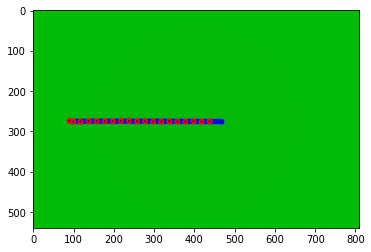

     fun: 0.005682218343323701
     jac: array([-1.42923107e-04, -1.27295254e-04,  0.00000000e+00, -1.69674301e-03,
        7.68412236e-04, -1.30992661e-03,  8.17772038e-29,  0.00000000e+00,
        8.17772038e-29,  0.00000000e+00,  8.17772038e-29,  0.00000000e+00,
        8.17772038e-29,  0.00000000e+00,  8.17772038e-29,  0.00000000e+00,
        8.17772038e-29,  0.00000000e+00,  2.22262247e-06,  7.19505910e-06,
       -7.90525295e-15,  0.00000000e+00, -7.90525295e-15,  0.00000000e+00,
        1.02303273e-14,  0.00000000e+00, -7.90525295e-15,  0.00000000e+00,
        1.02303273e-14,  0.00000000e+00, -7.90525295e-15,  0.00000000e+00,
       -7.90525295e-15,  0.00000000e+00,  1.02303273e-14,  0.00000000e+00,
        1.02303273e-14, -1.13579450e-29])
 message: 'Positive directional derivative for linesearch'
    nfev: 3304
     nit: 536
    njev: 532
  status: 8
 success: False
       x: array([275.53736133, 119.00860059, 275.68761657,  99.        ,
       275.74851994, 118.98412431, 276.

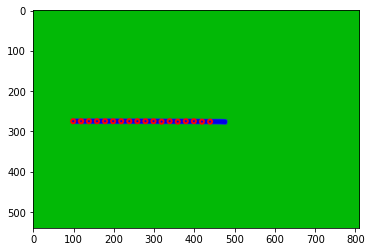

     fun: 756690.7877076484
     jac: array([ -2.6643086 ,  30.27748587,  -7.93037521,   9.25588708,
        -3.57822602,  31.31508214,  -5.57142461,  52.26203368,
        -5.49829032,  73.21256189,  -4.40711996,  94.15960013,
        -5.43652455, 115.1023426 ,  -5.42054673, 136.0457462 ,
        -4.3661211 , 156.98927251,  -4.3590825 , 177.93202207,
        -5.39369339, 197.82725249,  -5.38812069, 218.76990892,
        -3.34886183, 239.71291349,  -4.34255798, 260.65524464,
        -3.34448001, 281.59790409,  -4.33769587, 302.54024564,
        -4.33574445, 323.48272482,  -3.34391235,   0.        ,
        -4.33919663,   0.        ])
 message: 'Optimization terminated successfully'
    nfev: 5818
     nit: 805
    njev: 805
  status: 0
 success: True
       x: array([272.82938524, 511.92202782, 269.59617318, 492.18509948,
       271.13121363, 512.12610367, 269.55337271, 532.06376734,
       269.77005322, 552.06259365, 270.37421858, 572.05346619,
       269.36654162, 592.02806474, 269.28

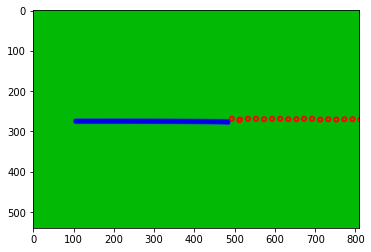

     fun: 1936212.8997087765
     jac: array([ 3.34964959,  0.        ,  4.34664263,  0.        ,  4.34664263,
        0.        ,  5.38476231,  0.        , 11.7157204 ,  0.        ,
       10.65914288,  0.        , 12.77232401,  0.        , 13.82894546,
        0.        , 14.88558263,  0.        , 10.65914288,  0.        ,
        9.60261829,  0.        ,  9.60261829,  0.        , 10.65914288,
        0.        , 10.65914288,  0.        , 11.7157204 ,  0.        ,
       13.82894546,  0.        , 15.94223529,  0.        , 14.88558263,
        0.        , 12.77232401,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 15213
     nit: 1951
    njev: 1949
  status: 0
 success: True
       x: array([ 282.45751757, 1824.48177538,  283.3760582 , 1844.46067128,
        283.15957299, 1864.45949972,  284.52264217, 1844.50600268,
        290.38418126, 1825.38422559,  289.65681088, 1805.39745672,
        291.07706306, 1785.44794838,  292.95077336, 1805.35998525,
        29

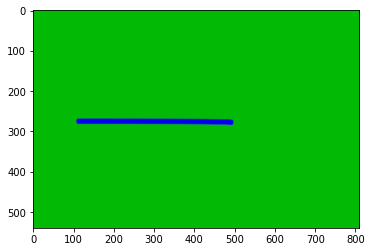

     fun: 1707864.4086947609
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])
 message: 'Iteration limit reached'
    nfev: 46138
     nit: 5000
    njev: 4998
  status: 9
 success: False
       x: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
one iteration takes: 3.5023353099823


ValueError: cannot convert float NaN to integer

In [121]:
# simple rope tracking for LSLQP
H = 540
W = 810
l = 20
simple_tracker_sub = indi_pt_tracker(H, W, l)
p = np.zeros((19,2))
p[:,0] = 10
p[:,1] = np.arange(40, 401, l)
simple_tracker_sub.set_init(p)
data_path = "/home/yixuan/dart_deformable/data/rope_simple/"
for i in range(251):
    rgb_np = exr_to_np(data_path+"rgb_"+'{0:03d}'.format(i)+".exr")
    mask = rgb_np[:, :, 2] > 100
    simple_tracker_sub.set_obs(mask, rgb_np)
    start = time.time()
    simple_tracker_sub.step()
    print("one iteration takes:", time.time()-start)
    simple_tracker_sub.vis(save_dir="/home/yixuan/dart_deformable/result/LSLQP_rope_simple_obj_loss/", idx=i)

In [142]:
s=sign_nozero(np.zeros(10))

In [145]:
s[s==0]=1

In [146]:
s

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])